# Problem 3: TensorFlow and Edge Detection using SVM

In [1]:
%matplotlib inline
from __future__ import division
from ipywidgets import interact
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import shutil
from utils import *
from HOG import *

Your task is to construct a SVM using the tf.estimator framework.
We have written most of the tf.estimator framework and generated the data. Your task is to fill in the feature extractor section and the **``` model_fn ``` ** function below. Please read through the Tensorflow Example IPython Notebook first.


First, we generate the data.

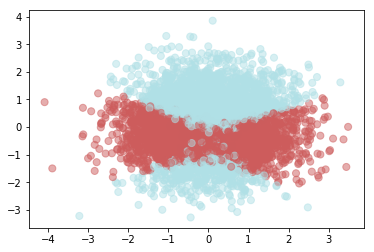

In [2]:
# Cell [a]
# generating data!
x_train, y_train = generate_data(N=5000)
x_eval, y_eval = generate_data(N=1000)
x_pred, y_true = generate_data(N=1000)
c = ['powderblue' if lb == 1 else 'indianred' for lb in y_train]
plt.scatter(x_train[:,0], x_train[:,1], c = c, alpha=0.5, s=50)

### Edit in Part (iv), but still run for Part(iii)

In [3]:
# Cell [b]
# Here, you need to define your features. You should use numpy operations.
# Feature extractor
def identityFeatureExtractor(x):
    return x
def customFeatureExtractor(x):
    # You need to write a feature extractor
    # It takes in x, a N x 2 array and outputs features of your design.
    # It should output a N x M array where M is the number of features
    # For example, it can output x1, x2, x1*x2
    ### Your code starts here ###
    N = x.shape[0]
    x = x.astype(np.float32)
    x1, x2 = x[:, 0].reshape(N, -1), x[:, 1].reshape(N, -1)
    abs_slope = np.absolute(np.divide(x2, x1))
    abs_x1x2 = np.absolute(x1) * np.absolute(x2)
    
    features = np.hstack([x1, x2, np.exp(np.absolute(x1)), np.exp(np.absolute(x2)), abs_slope, abs_x1x2])
    assert features.shape == (x.shape[0], 6)
    #############################
    return features

########## TO DO #######################
# Select which feature extractor you want
# featureExtractor = identityFeatureExtractor
featureExtractor = customFeatureExtractor

We start building the Estimator framework.
Make sure you define lambda here

In [16]:
# Cell [c]
## Settings for the estimator
# location to save model information
model_dir = "training_checkpoints"
rc = tf.estimator.RunConfig().replace(model_dir=model_dir,
                                      tf_random_seed=None,
                                      save_summary_steps=100,
                                      save_checkpoints_steps=1000,
                                      keep_checkpoint_max=1000,
                                      log_step_count_steps=1000)

# hyperparameters, batch sizes, learning rate
hps = tf.contrib.training.HParams(
    train_batch_size = 32,
    eval_batch_size = 32,
    ############ Select your learning rate and lambda value here ############
    # lr = 1.5e-2,
    # lam = 1e-4,
    # another pair of params that also work
    lr = 0.02,
    lam = 0.0001
    #########################################################################
    )


### Part (iii)
```model_fn``` is defined here. Your task is to fill in the missing code

In [17]:
# Cell [d]
# Defining necessary functions for the estimator 
# input data functions for train, evalulation and prediction
# note that x and y are fed in as dictionaries
train_input_function = tf.estimator.inputs.numpy_input_fn(x={"x":featureExtractor(x_train)},
                                                          y={"y":y_train},
                                                          batch_size=hps.train_batch_size,
                                                          num_epochs=None,
                                                          shuffle=True)
eval_input_function = tf.estimator.inputs.numpy_input_fn(x={"x":featureExtractor(x_eval)},
                                                         y={"y":y_eval},
                                                         batch_size=hps.eval_batch_size,
                                                         num_epochs=1,
                                                         shuffle=False)
def predict_input_function(x_dict):
    return tf.estimator.inputs.numpy_input_fn(x=x_dict,
                                              num_epochs=1,
                                              shuffle=False)


def model_fn(features, labels, mode, params):
    predictions = None
    loss = None
    train_op = None
    eval_metric_ops = None 
    export_outputs = None

    x = tf.to_float(features["x"])
    if mode == tf.estimator.ModeKeys.TRAIN or mode == tf.estimator.ModeKeys.EVAL:
        y = tf.to_float(labels["y"])
        with tf.variable_scope("svm"):
            W = tf.get_variable("weights", dtype=tf.float32, shape=(x.shape[-1],1))
            b = tf.get_variable("bias", dtype=tf.float32, shape=(1,))
            ### Your code starts here ###
            # You may find the following functions useful: tf.matmul, tf.reduce_mean, tf.maximum, tf.square, tf.nn.l2_loss, tf.reduce_sum
            # use the ?<function name> functionality in jupyter to find out more about the functions.
            # This should take about 2 lines.
            ###########################
            y_est = tf.matmul(x, W) - b
            loss = tf.reduce_mean(tf.maximum(0.0, 1-y*y_est)) + hps.lam * tf.norm(W)**2
            #####
            accuracy = tf.reduce_mean(tf.to_float(y*y_est > 0))
            eval_metric_ops = {"accuracy": tf.metrics.mean(accuracy)}
            if mode == tf.estimator.ModeKeys.TRAIN:
                opt = tf.train.GradientDescentOptimizer(learning_rate=params.lr)
                train_op = opt.minimize(loss, tf.train.get_global_step())
    elif mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {}
        with tf.variable_scope("svm"):
            W = tf.get_variable("weights", shape=(x.shape[-1],1), dtype=tf.float32)
            b = tf.get_variable("bias", shape=(1,), dtype=tf.float32)
            ### Your code starts here ###
            # This should take about 1 line
            #############################
            y_est = tf.matmul(x, W) - b
            #####
            predictions["y_est"] = y_est
            predictions["labels"] = 2*tf.sign(y_est) - 1
    return tf.estimator.EstimatorSpec(mode, 
                                      predictions=predictions, 
                                      loss=loss,
                                      train_op=train_op,
                                      eval_metric_ops=eval_metric_ops)

In [18]:
# Cell [e]
# Define the estimator object
estimator_model = tf.estimator.Estimator(model_fn, 
                                         params=hps, 
                                         config=rc,
                                         model_dir=model_dir,
                                         )

INFO:tensorflow:Using config: {'_save_checkpoints_secs': None, '_session_config': None, '_keep_checkpoint_max': 1000, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff854197d90>, '_save_checkpoints_steps': 1000, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 1000, '_model_dir': 'training_checkpoints', '_save_summary_steps': 100}


In [19]:
# Cell [f]
# Define the specifications for training and evaluation
train_spec = tf.estimator.TrainSpec(input_fn=train_input_function, max_steps=10000)
eval_spec = tf.estimator.EvalSpec(input_fn=eval_input_function, steps=100, start_delay_secs=0)

In [20]:
# Cell [g]
# Clear graph and start training and evaluating the model
shutil.rmtree(model_dir, ignore_errors=True)
tf.estimator.train_and_evaluate(estimator_model, train_spec, eval_spec)

INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after 600 secs (eval_spec.throttle_secs) or training is finished.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into training_checkpoints/model.ckpt.
INFO:tensorflow:loss = 1.1549343, step = 1
INFO:tensorflow:loss = 0.20768213, step = 101 (0.059 sec)
INFO:tensorflow:loss = 0.064904, step = 201 (0.047 sec)
INFO:tensorflow:loss = 0.16837892, step = 301 (0.040 sec)
INFO:tensorflow:loss = 0.18284512, step = 401 (0.044 sec)
INFO:tensorflow:loss = 0.12548979, step = 501 (0.045 sec)
INFO:tensorflow:loss = 0.078331105, step = 601 (0.043 sec)
INFO:tensorflow:loss = 0.06851408, step = 701 (0.046 sec)
INFO:tensorflow:loss = 0.15984859, step = 801 (0.044 sec)
INFO:tensorflow:loss = 0.14133058, step = 901 (0.051 sec)
INFO:tensorflow:Saving checkpoints for 1001 into training_checkpoints/model.ckpt.
INFO:tensorflow:gl

In [21]:
# Cell [g]
# Make predictions given new x data
y_predict = estimator_model.predict(predict_input_function({"x":featureExtractor(x_pred)}), predict_keys = "y_est")
y_pred = [y["y_est"][0] for y in y_predict]
labels_pred = np.sign(np.array(y_pred))

INFO:tensorflow:Restoring parameters from training_checkpoints/model.ckpt-10000


Misclassfication rate of test data: 0.055


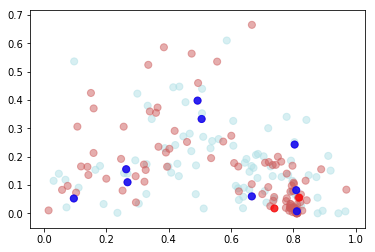

In [22]:
# Cell[i]
# Plot predictions
c = ['powderblue' if lb == 1 else 'indianred' for lb in labels_pred]
plt.scatter(x_pred[:,0], x_pred[:,1], c=c, s=50, alpha=0.5)
# misclassified data
d = labels_pred - y_true[:,0]
misclass_idx = np.where(d!= 0)[0]
c = ['red' if lb == 2 else 'blue' for lb in d[misclass_idx]]
plt.scatter(x_pred[misclass_idx,0], x_pred[misclass_idx,1], c=c, s=50, alpha=0.8)
print("Misclassfication rate of test data: {}".format(float(misclass_idx.shape[0])/float(y_true.shape[0])))

### Part (vii) SVM with Histograms of Gradients


In [11]:
# Cell [j]
sess = tf.InteractiveSession()
datasets = np.load('pedestrian_dataset.npz')    # extracted from the original Dalal and Triggs paper dataset available here: http://pascal.inrialpes.fr/data/human/
datasets.keys()

['eval_neg', 'train_neg', 'test_pos', 'eval_pos', 'train_pos', 'test_neg']

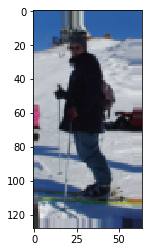

In [12]:
# Cell [k]
### EXPLORE THE DATASET!
data = datasets['train_pos']
# data = datasets['train_neg']
@interact(k = (0, data.shape[0]-1))
def view_img(k):
    plt.imshow(data[k])

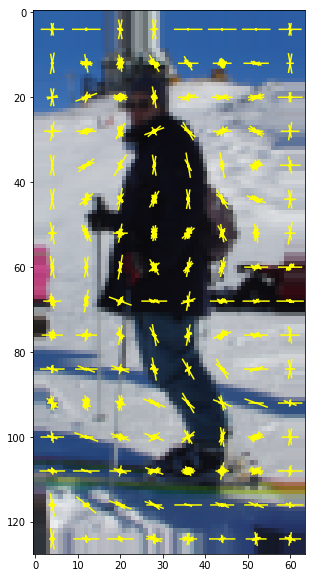

In [14]:
# Cell[l]
### VISUALIZE HOGs!
data = datasets['train_pos']
# data = datasets['train_neg']

@interact(k = (0, data.shape[0]-1))
def view_img(k):
    plt.figure(figsize = (10,10))    # feel free to change this depending on your screen resolution
    plt.imshow(data[k])
    # we can call .eval() instead of sess.run() below since we're using an InteractiveSession
    plot_cell_hogs(tf_histogram_of_oriented_gradients(data[k])[0].eval())

In [15]:
# Cell [m]
### USE TENSORFLOW AS A COMPUTATION FRAMEWORK (NOT JUST FOR BACKPROPAGATION!)
##### You code starts here #####
############################################################
train_pos, train_neg = datasets['train_pos'], datasets['train_neg'] # shape: (N, 128, 64, 3)
eval_pos, eval_neg = datasets['eval_pos'], datasets['eval_neg']
test_pos, test_neg = datasets['test_pos'], datasets['test_neg']

# NOTE: we need to pass in Xs and Ys as numpy arrays, so call eval() on tensors
# Window size: 8x8, Image: 128x64 (16x8 windows), Each window 9 bins, HOG Vector: 16x8x9=1152 dimension
# Xs should be of size [#datapoints, 1152] 
x_train = tf_histogram_of_oriented_gradients(np.vstack([train_pos, train_neg]))[1].eval()
x_eval = tf_histogram_of_oriented_gradients(np.vstack([eval_pos, eval_neg]))[1].eval()
x_pred = tf_histogram_of_oriented_gradients(np.vstack([test_pos, test_neg]))[1].eval()

# Extract sizes
train_size, eval_size, test_size = x_train.shape[0], x_eval.shape[0], x_pred.shape[0]

# Ys should be of size [#datapoints, 1]
y_train = np.array([1]*train_pos.shape[0] + [-1]*train_neg.shape[0], dtype=np.float32).reshape(train_size, 1)
y_eval = np.array([1]*eval_pos.shape[0] + [-1]*eval_neg.shape[0], dtype=np.float32).reshape(eval_size, 1)
y_true = np.array([1]*test_pos.shape[0] + [-1]*test_neg.shape[0], dtype=np.float32).reshape(test_size, 1)
ys = [y_train, y_eval, y_true]

for i, y in enumerate(ys):
    ys[i] = tf.convert_to_tensor(y).eval()
    
y_train, y_eval, y_true = ys

############################################################
featureExtractor = identityFeatureExtractor

In [ ]:
### RERUN TRAINING CELLS [c]-[g] ABOVE

HOG.py:52: RuntimeWarning: invalid value encountered in true_divide
  cell_hogs_normalized = np.squeeze(cell_hogs / np.linalg.norm(cell_hogs, axis=-1, keepdims=True))


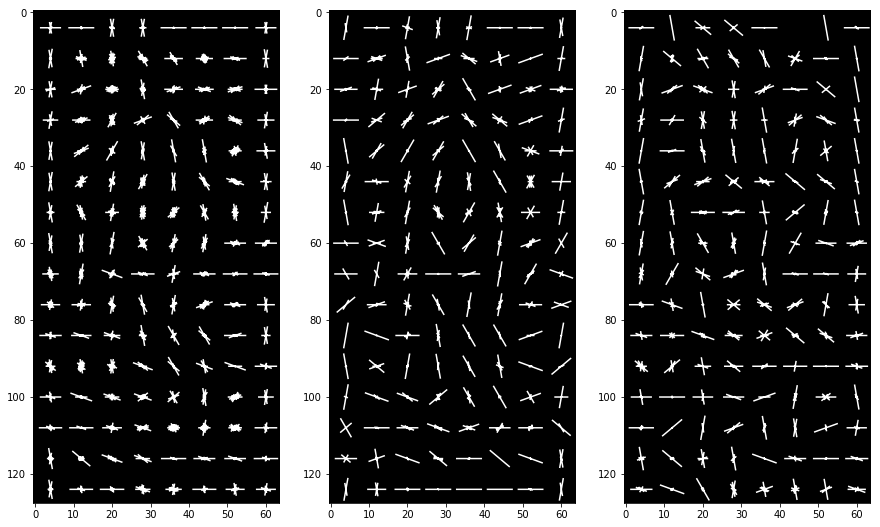

In [23]:
# Cell [n]
### VISUALIZE WEIGHTED HOGs!
data = datasets['train_pos']
# data = datasets['train_neg']

weights = np.reshape(estimator_model.get_variable_value('svm/weights'), [1, -1])
pos_weights = np.maximum(weights, 0)
neg_weights = -np.minimum(weights, 0)
@interact(k = (0, data.shape[0]-1), show_image = (False, True))
def view_img(k, show_image):
    plt.figure(figsize = (15,15))    # feel free to change this depending on your screen resolution
    plt.imshow(data[k])
    hog = hog_descriptor(data[k]).eval()
    unweighted_block_hogs = np.mean(hog.reshape([16, 8, 1, 9]), axis=2)
    pos_weighted_block_hogs = np.mean(pos_weights.reshape([16, 8, 1, 9])*hog.reshape([16, 8, 1, 9]), axis=2)
    neg_weighted_block_hogs = np.mean(neg_weights.reshape([16, 8, 1, 9])*hog.reshape([16, 8, 1, 9]), axis=2)

    plt.subplot(1,3,1)
    color = 'yellow' if show_image else 'white'
    plt.imshow(show_image*data[k])
    plot_cell_hogs(unweighted_block_hogs, pixels_in_cell=8, color=color)
    plt.subplot(1,3,2)
    plt.imshow(show_image*data[k])
    plot_cell_hogs(pos_weighted_block_hogs, pixels_in_cell=8, color=color)
    plt.subplot(1,3,3)
    plt.imshow(show_image*data[k])
    plot_cell_hogs(neg_weighted_block_hogs, pixels_in_cell=8, color=color)